In [1]:
import logging
from networkx import Graph
from numpy.random import randint

from gensim.models import Doc2Vec
from gensim.models.doc2vec import LabeledSentence

import numpy as np
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

from pandas import DataFrame

import matplotlib.pyplot as plt
from matplotlib import collections as mc
from pylab import rcParams, subplots

rcParams['figure.figsize'] = (25, 15)

from fastcluster import linkage
from scipy.cluster.hierarchy import cophenet, fcluster, dendrogram
from scipy.spatial.distance import pdist

from sklearn.cluster import KMeans

logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s',
                    level=logging.INFO,
                    filename='../log/facebook.log')

In [2]:
SOURCE_PATH = '../datasets/facebook_combined.txt'

nodes = set([])
pairs = []

with open(SOURCE_PATH, 'r') as fin:
    for line in fin:
        xs = [x.strip() for x in line.split(' ')]
        nodes.update(xs)
        pairs += [xs]

# make graph, add nodes  
graph = Graph()
nodes = list(nodes)
graph.add_nodes_from(nodes)

# add edges (symmetrically)
graph.add_edges_from(pairs)
graph.add_edges_from([(y,x) for x,y in pairs])

In [3]:
def random_neighbor(x, graph=graph):
    ys = list(graph[x].keys())
    return ys[randint(low=0, high=len(ys))]


def random_chain(length, x0=None, graph=graph, nodes=nodes):
    if x0 is None:
        x0 = nodes[randint(low=0, high=len(nodes))]
    x = x0
    ys = [x0]
    for _ in range(length - 1):
        y = random_neighbor(x, graph)
        ys += [y]
        x = y
    return ys


class GraphRandomWalk(object):
    def __init__(self, n_chains, chain_len):
        self.n_chains = n_chains
        self.chain_len = chain_len
    def __iter__(self):
        for _ in range(self.n_chains - len(nodes)):
            # generate a chain
            chain = random_chain(self.chain_len)
            yield LabeledSentence(words=chain, tags=[chain[0]])
        for node in nodes:
            chain = random_chain(self.chain_len, node)
            yield LabeledSentence(words=chain, tags=[chain[0]])


def train_model(size, window):
    return Doc2Vec(GraphRandomWalk(80000, 25),
                   workers=5,
                   size=size, window=window, negative=20,
                   iter=10, alpha=0.1, min_count=1, sample=0)


# two models, different degrees of seperation
model_far = train_model(80, 6)
model_near = train_model(80, 2)

sum(pca.explained_variance_ratio_) ==  0.460373191226
tsne.kl_divergence_ ==  1.7230193614959717


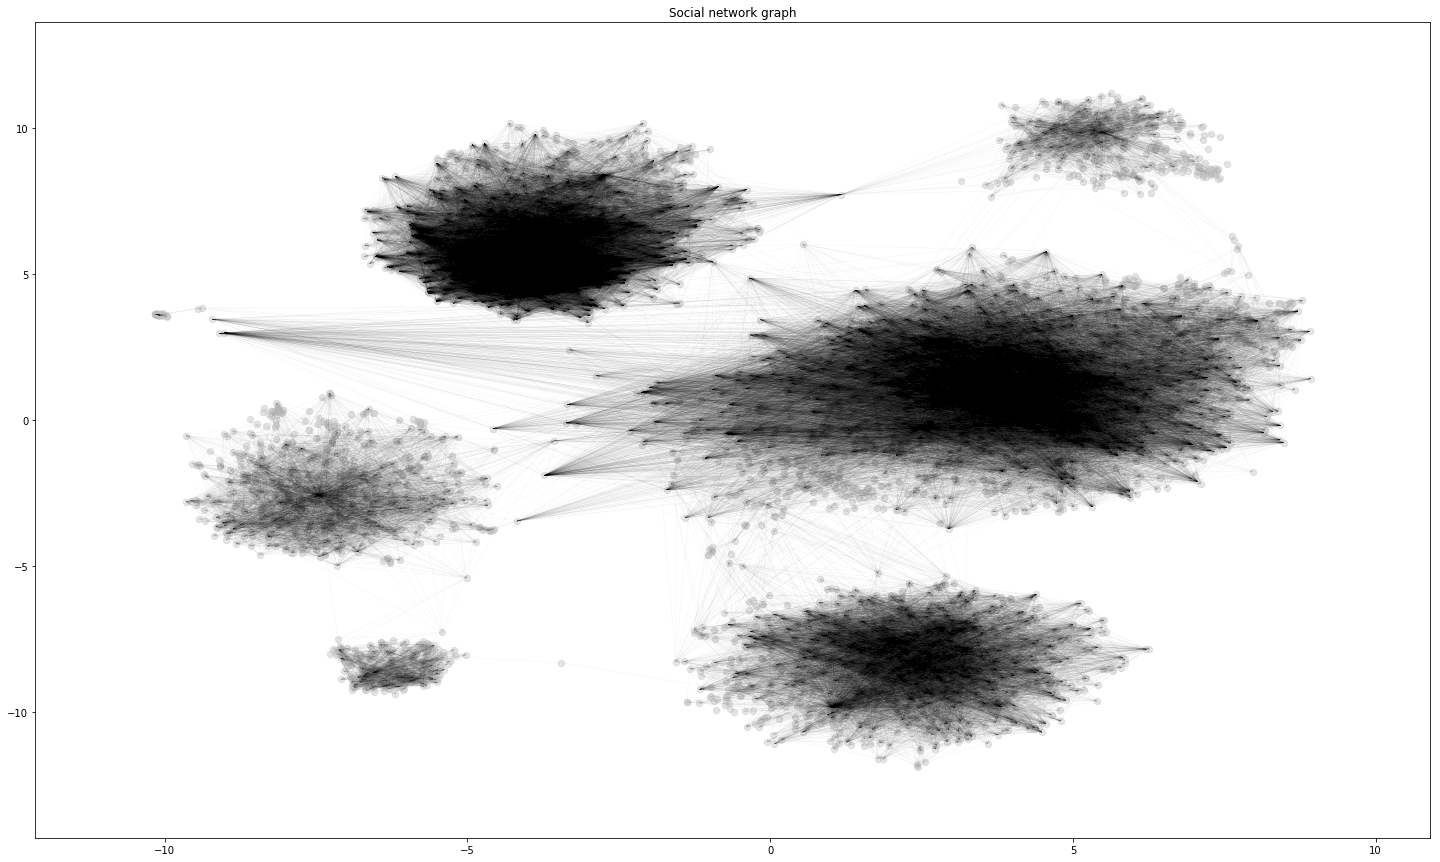

In [4]:
"""plot users and friendships in t-SNE space
using mostly the doc vectors
"""

# PCA, t-SNE 

users = list(model_far.wv.vocab.keys())
X1 = np.hstack([model_far.docvecs[users],
               model_near.docvecs[users],
               0.33 * model_near[users]])

pca = PCA(50)
tsne = TSNE(2, metric='cosine', verbose=0)

Y1 = pca.fit_transform(X1)
Z1 = tsne.fit_transform(Y1)

print('sum(pca.explained_variance_ratio_) == ', np.sum(pca.explained_variance_ratio_))
print('tsne.kl_divergence_ == ', tsne.kl_divergence_)

# map from user to x,y
dim_user1 = (DataFrame({'user': users,
                           'x': [Z1[:, 0][users.index(u)] for u in users],
                           'y': [Z1[:, 1][users.index(u)] for u in users]})
             .set_index('user'))


# friendships and their users' x,y's
dim_friendship1 = (DataFrame({'user_1': [a for a,_ in pairs],
                              'user_2': [b for _,b in pairs]})
                   .join(dim_user1, on='user_1')
                   .join(dim_user1, on='user_2', rsuffix='2'))

def make_line(row):
    return [(row.x, row.y), (row.x2, row.y2)]

lines1 = list(dim_friendship1.apply(make_line, 1))

lc = mc.LineCollection(lines1, linewidths=0.05, color = np.array([0, 0, 0, 0.4]))
fig, ax = subplots()
ax.add_collection(lc)
ax.autoscale()
ax.margins(0.1)

plt.scatter(Z1[:, 0], Z1[:, 1], s = 40, c = np.array([0.75, 0.75, 0.75, 0.4]))
plt.title('Social network graph')
plt.show()

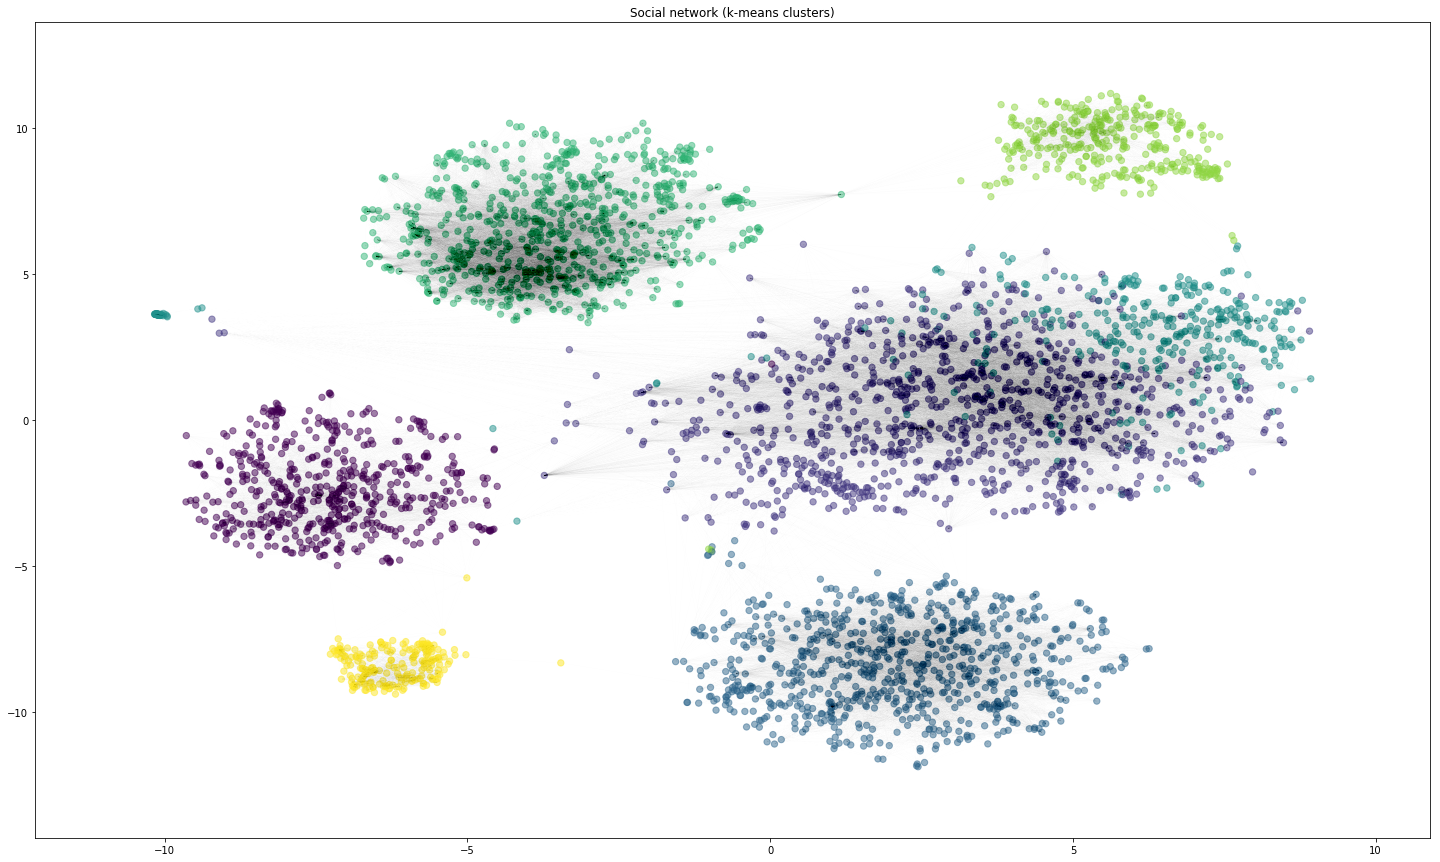

In [5]:
"""k-means clustering"""

C_kmeans = KMeans(7).fit_predict(X1)

lc = mc.LineCollection(lines1, linewidths=0.01, color = np.array([0, 0, 0, 0.2]))
fig, ax = subplots()
ax.add_collection(lc)
ax.autoscale()
ax.margins(0.1)

plt.scatter(Z1[:, 0], Z1[:, 1], s=40, c=C_kmeans, alpha=0.5)
plt.title('Social network (k-means clusters)')
plt.show()

0.666449105706


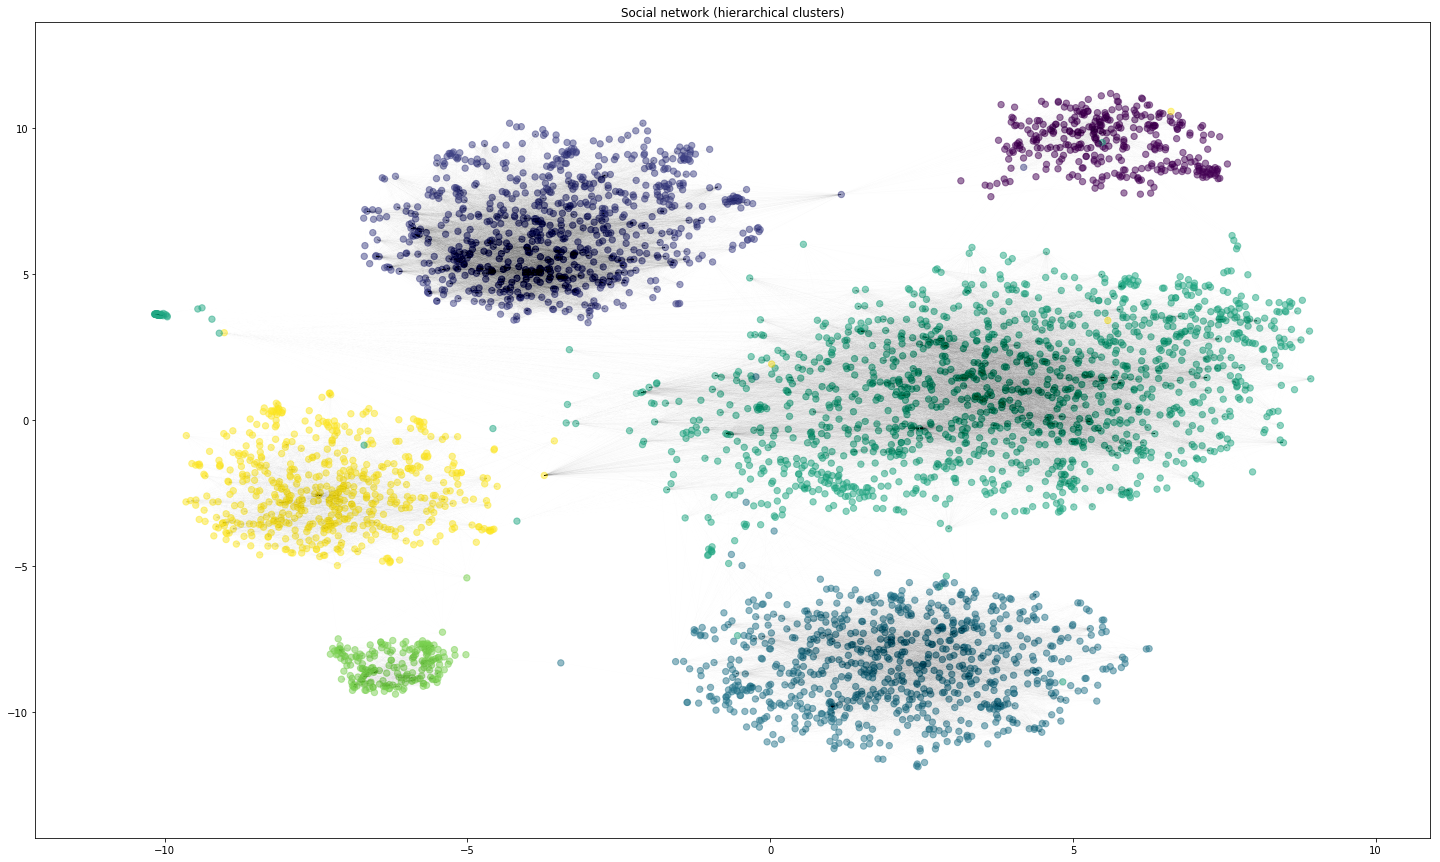

In [6]:
"""hierarchical clustering"""

W = linkage(X1, method='ward', metric='cosine')
C_hierarchy = fcluster(W, 6, criterion='maxclust')

c, coph_dists = cophenet(W, pdist(Z1))
print(c)

lc = mc.LineCollection(lines1, linewidths=0.01, color = np.array([0, 0, 0, 0.2]))
fig, ax = subplots()
ax.add_collection(lc)
ax.autoscale()
ax.margins(0.1)

plt.scatter(Z1[:, 0], Z1[:, 1], s=40, c=C_hierarchy, alpha=0.5)
plt.title('Social network (hierarchical clusters)')
plt.show()

In [7]:
def friendships_explained(C):
    """returns the fraction of friendships explained by the clusters"""
    dim_cluster = (DataFrame({'user': users,
                                 'c': list(C)})
                   .set_index('user'))

    whether_friendships_cluster = (dim_friendship1
     .join(dim_cluster, on='user_1')
     .join(dim_cluster, on='user_2', rsuffix='2')
     .apply(lambda row: row.c == row.c2, 1))

    return len(dim_friendship1[whether_friendships_cluster]) * 1.0 / len(dim_friendship1)


print("kmeans explains", friendships_explained(C_kmeans))
print("kmeans hierarchical", friendships_explained(C_hierarchy))

kmeans explains 0.9747716299839064
kmeans hierarchical 0.9882018269601287


sum(pca.explained_variance_ratio_) ==  0.472318921144
tsne.kl_divergence_ ==  1.2941827774047852


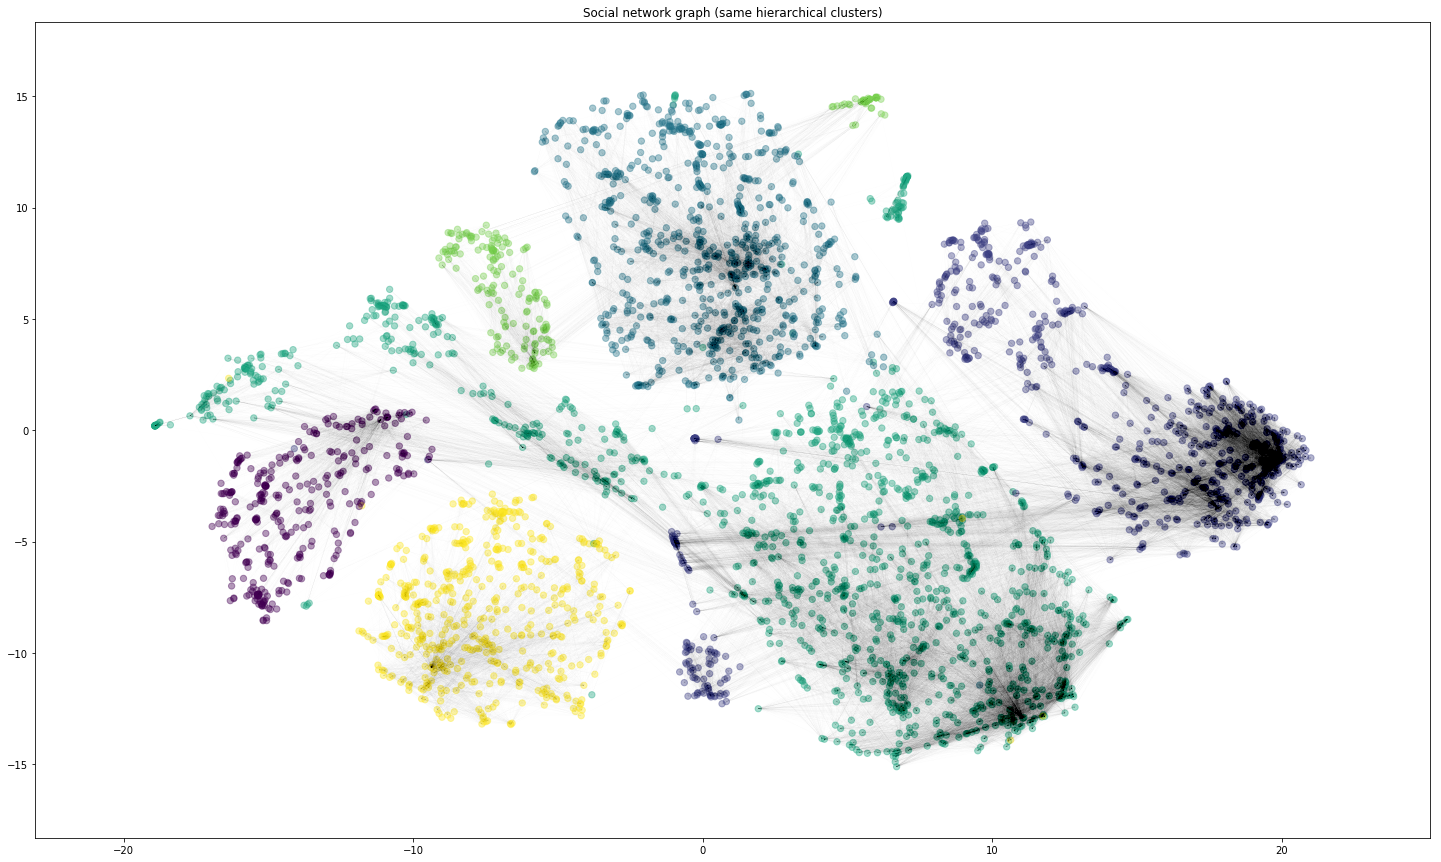

In [8]:
"""using word vectors and doc vectors"""

X2 = np.hstack([model_near.docvecs[users],
               model_far.docvecs[users],
               model_near[users],
               model_far[users]])

pca = PCA(50)
tsne = TSNE(2, metric='cosine', verbose=0)

Y2 = pca.fit_transform(X2)
Z2 = tsne.fit_transform(Y2)

print('sum(pca.explained_variance_ratio_) == ', np.sum(pca.explained_variance_ratio_))
print('tsne.kl_divergence_ == ', tsne.kl_divergence_)

# map from key to coordinate
dim_user2 = (DataFrame({'user': users,
                           'x': Z2[:, 0],
                           'y': Z2[:, 1]})
             .set_index('user'))

# pairs (edges/friendships) and their coordinates
dim_friendships2 = (DataFrame({'user_1': [a for a,_ in pairs],
                               'user_2': [b for _,b in pairs]})
                    .join(dim_user2, on='user_1')
                    .join(dim_user2, on='user_2', rsuffix='2'))

def make_line(row):
    return [(row.x, row.y), (row.x2, row.y2)]

lines2 = list(dim_friendships2.apply(make_line, 1))

lc = mc.LineCollection(lines2, linewidths=0.01, color = np.array([0, 0, 0, 0.4]))
fig, ax = subplots()
ax.add_collection(lc)
ax.autoscale()
ax.margins(0.1)

plt.scatter(Z2[:, 0], Z2[:, 1], s = 40, c=C_hierarchy, alpha=0.4)
plt.title('Social network graph (same hierarchical clusters)')
plt.show()